# Import library and check versions of Cuda and CuDNN

In [1]:
import tensorflow as tf
from ParticleNet import get_particle_net

gpu = True
if not gpu:
# Establecer para que TensorFlow solo use CPU
  tf.config.set_visible_devices([], 'GPU')

# Verificar si solo se está usando CPU
  print("Dispositivos físicos disponibles:", tf.config.list_physical_devices('GPU'))

# Tu código de TensorFlow aquí
!export LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH

# !export LD_LIBRARY_PATH=/mnt/c/Users/olmic/Desktop/Personal/Máster/TFM/Código/TFM-CTLearn/cudnn/cudnn-linux-x86_64-8.9.2.26_cuda11-archive/lib:$LD_LIBRARY_PATH
# !export CUDNN_INCLUDE_DIR=/mnt/c/Users/olmic/Desktop/Personal/Máster/TFM/Código/TFM-CTLearn/cudnn/cudnn-linux-x86_64-8.9.2.26_cuda11-archive/include


2024-07-11 12:29:25.511980: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 12:29:25.543075: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 12:29:25.543104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 12:29:25.543180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 12:29:25.550384: I tensorflow/core/platform/cpu_feature_g

In [2]:
print("CUDA version:", tf.sysconfig.get_build_info()["cuda_version"])
print("CuDNN version:", tf.sysconfig.get_build_info()["cudnn_version"])

CUDA version: 11.8
CuDNN version: 8


In [3]:
# Mostramos la versión de tensorflow instalada
print(tf.__version__)

2.14.1


# Configure Log Dir, EarlyStopping and ReduceLROnPlateau

In [16]:
# Logging and learning control
import logging
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

# Configurar el logger de Python
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Callback personalizado para logging
class LoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logger.info(f"Epoch {epoch + 1}, Loss: {logs['loss']}, Accuracy: {logs['accuracy']}, Val Loss: {logs['val_loss']}, Val Accuracy: {logs['val_accuracy']}")

# Configurar TensorFlow para usar el logger de Python
tf.get_logger().setLevel('INFO')

# Callback para reducir el learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0
)

# Callback para detener el entrenamiento temprano si no hay mejora
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Configurar el callback de TensorBoard
tensorboard_callback = TensorBoard(log_dir='../logs/PCT_low_data/', histogram_freq=1)

# Prepare model model saving directory.
import os
save_dir = '../logs/PCT_low_data/model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % 'PCT_low_data'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

callbacks=[LoggingCallback(), reduce_lr, early_stopping, tensorboard_callback, checkpoint]


# Create Model

In [17]:
setting = dict()

# conv_params: list of tuple in the format (K, (C1, C2, C3))
setting["conv_params"] = [
    (16, (64, 64, 64)),
    (16, (128, 128, 128)),
    (16, (256, 256, 256)),
    ]
# conv_pooling: 'average' or 'max'
setting["conv_pooling"] = 'average'
# fc_params: list of tuples in the format (C, drop_rate)
setting["fc_params"] = [(256, 0.1), (128, 0.1), (64, 0.1)]

# Model parameters
num_classes = 2
input_shapes = {'points': (500, 2), 'features': (500, 2), 'mask': (500, 1)}


model = get_particle_net(num_classes, input_shapes)

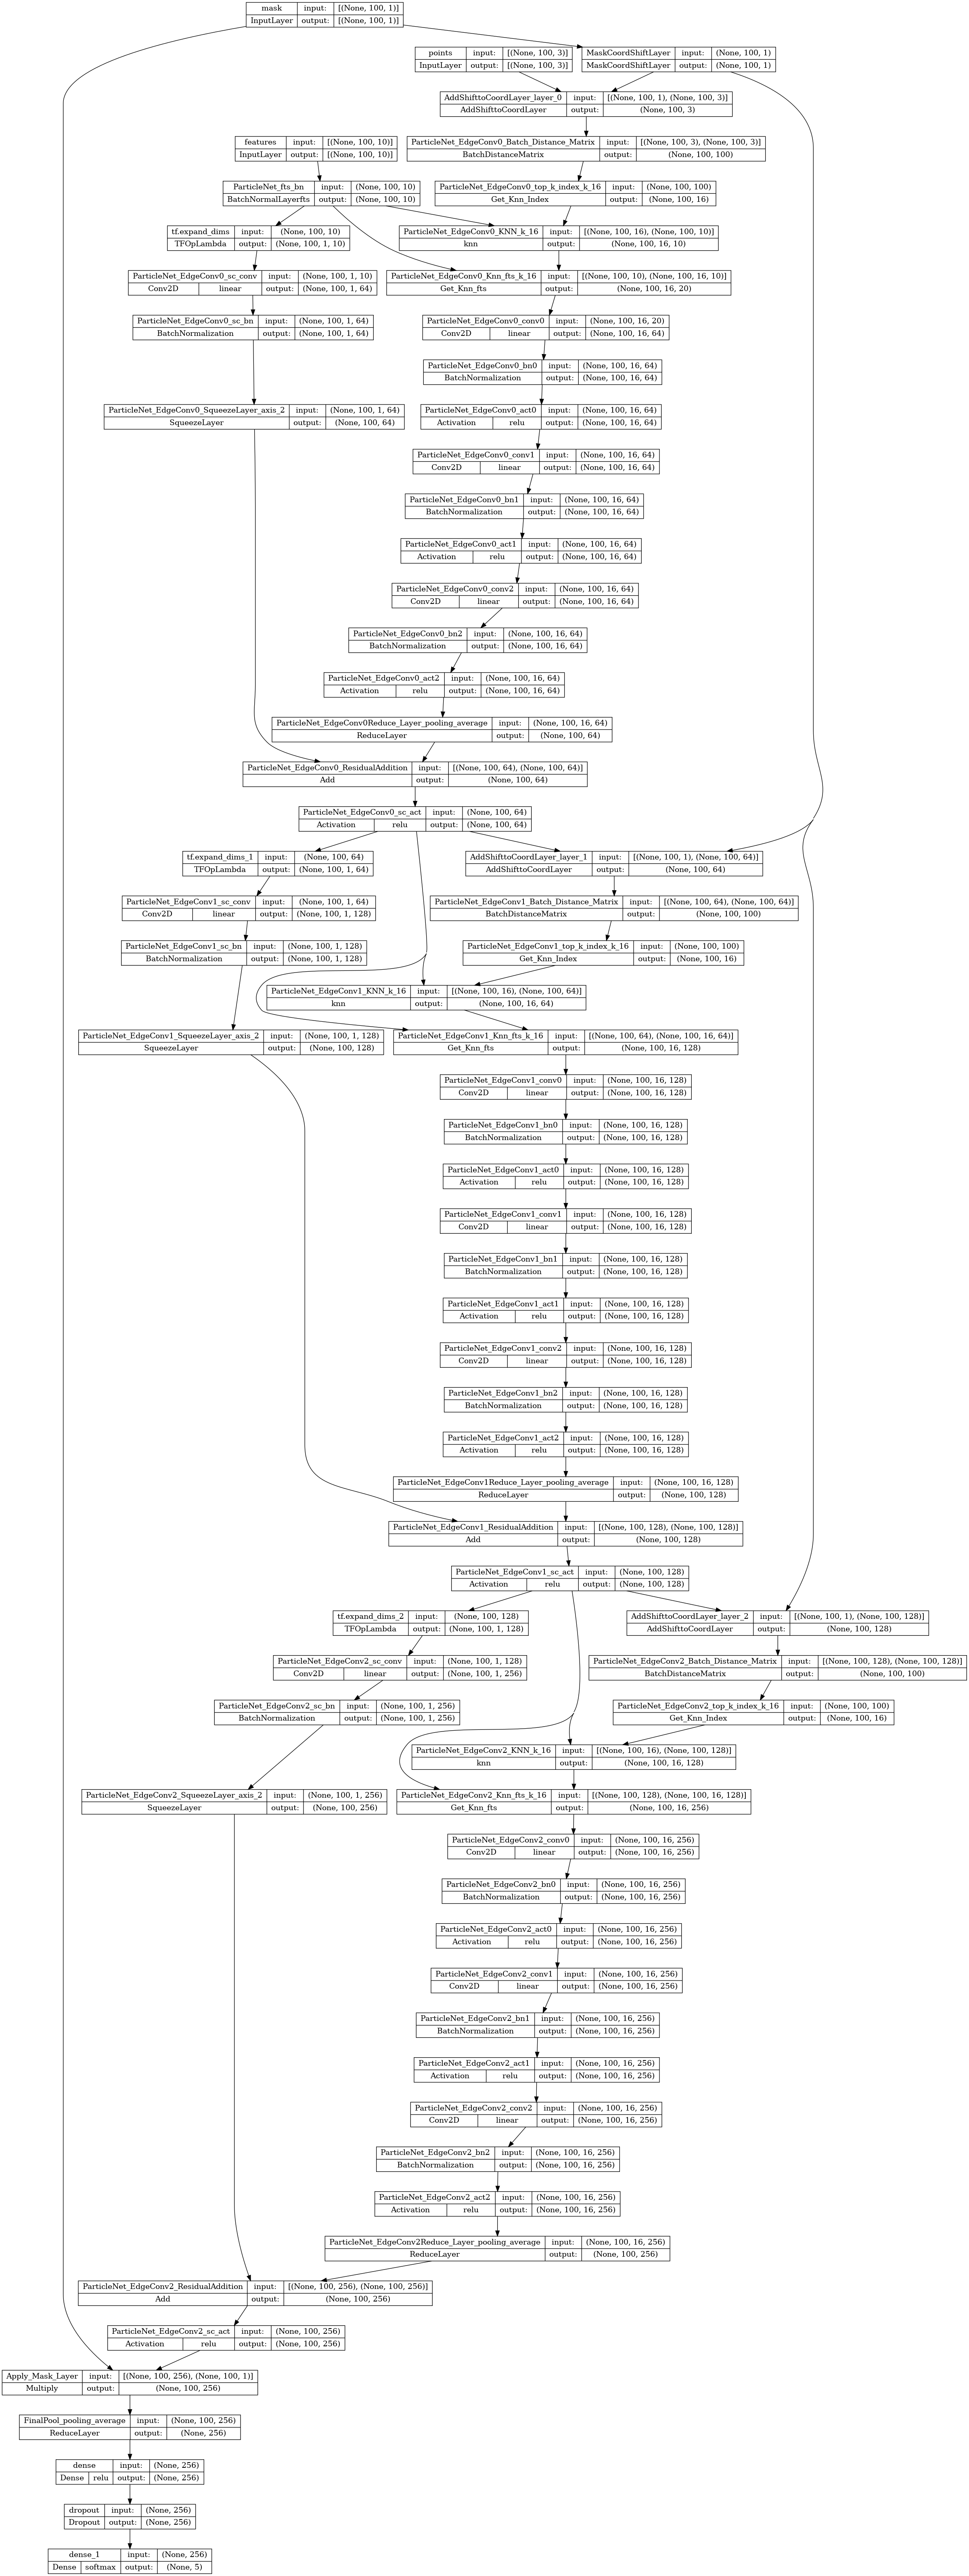

In [4]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names= True, show_layer_activations = True)

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mask (InputLayer)           [(None, 500, 1)]             0         []                            
                                                                                                  
 MaskCoordShiftLayer (MaskC  (None, 500, 1)               0         ['mask[0][0]']                
 oordShiftLayer)                                                                                  
                                                                                                  
 points (InputLayer)         [(None, 500, 2)]             0         []                            
                                                                                                  
 AddShifttoCoordLayer_layer  (None, 500, 2)               0         ['MaskCoordShiftLaye

                                                                                                  
 ParticleNet_fts_bn (BatchN  (None, 500, 2)               8         ['features[0][0]']            
 ormalLayerfts)                                                                                   
                                                                                                  
 ParticleNet_EdgeConv0_top_  (None, 500, 16)              0         ['ParticleNet_EdgeConv0_Batch_
 k_index_k_16 (Get_Knn_Inde                                         Distance_Matrix[0][0]']       
 x)                                                                                               
                                                                                                  
 ParticleNet_EdgeConv0_KNN_  (None, 500, 16, 2)           0         ['ParticleNet_EdgeConv0_top_k_
 k_16 (knn)                                                         index_k_16[0][0]',            
          

# Run Model

## Load Data

In [19]:
# Generación de datos
from DataLoader import PCDataGenerator
import h5py
import numpy as np

data_path = "../data/dataset_500_rel_coords.h5"
# Dividir el dataset en train, test y validation
with h5py.File(data_path, 'r') as f:
    all_indices = list(f.keys())

# Suponiendo que quieres una división 70% train, 15% validation, 15% test
np.random.shuffle(all_indices)
train_split = int(0.7 * len(all_indices))
val_split = int(0.85 * len(all_indices))

train_indices = all_indices[:train_split]
val_indices = all_indices[train_split:val_split]
test_indices = all_indices[val_split:]

# Crear generadores para cada partición
batch_size = 16
train_generator = PCDataGenerator(data_path, train_indices, batch_size=batch_size, shuffle=True)
val_generator = PCDataGenerator(data_path, val_indices, batch_size=batch_size, shuffle=True)
test_generator = PCDataGenerator(data_path, test_indices, batch_size=batch_size, shuffle=False)

## Train Model

In [20]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
358/358 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.8345

INFO:__main__:Epoch 1, Loss: 0.46921607851982117, Accuracy: 0.8344972133636475, Val Loss: 0.5011443495750427, Val Accuracy: 0.8314144611358643



Epoch 1: val_accuracy improved from -inf to 0.83141, saving model to ../logs/PCT_low_data/model_checkpoints/PCT_low_data_model.001.h5
358/358 [==============================] - 59s 152ms/step - loss: 0.4692 - accuracy: 0.8345 - val_loss: 0.5011 - val_accuracy: 0.8314 - lr: 0.0100
Epoch 2/50
358/358 [==============================] - ETA: 0s - loss: 0.4406 - accuracy: 0.8371

INFO:__main__:Epoch 2, Loss: 0.4406263828277588, Accuracy: 0.8371159434318542, Val Loss: 0.4733414351940155, Val Accuracy: 0.8322368264198303



Epoch 2: val_accuracy improved from 0.83141 to 0.83224, saving model to ../logs/PCT_low_data/model_checkpoints/PCT_low_data_model.002.h5
358/358 [==============================] - 56s 156ms/step - loss: 0.4406 - accuracy: 0.8371 - val_loss: 0.4733 - val_accuracy: 0.8322 - lr: 0.0100
Epoch 3/50
358/358 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8387

INFO:__main__:Epoch 3, Loss: 0.4354054033756256, Accuracy: 0.8386871218681335, Val Loss: 0.5828458666801453, Val Accuracy: 0.7804276347160339



Epoch 3: val_accuracy did not improve from 0.83224
358/358 [==============================] - 61s 170ms/step - loss: 0.4354 - accuracy: 0.8387 - val_loss: 0.5828 - val_accuracy: 0.7804 - lr: 0.0100
Epoch 4/50
358/358 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.8424

INFO:__main__:Epoch 4, Loss: 0.4280026853084564, Accuracy: 0.842353343963623, Val Loss: 0.44513997435569763, Val Accuracy: 0.8355262875556946



Epoch 4: val_accuracy improved from 0.83224 to 0.83553, saving model to ../logs/PCT_low_data/model_checkpoints/PCT_low_data_model.004.h5
358/358 [==============================] - 73s 205ms/step - loss: 0.4280 - accuracy: 0.8424 - val_loss: 0.4451 - val_accuracy: 0.8355 - lr: 0.0100
Epoch 5/50
358/358 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.8467

INFO:__main__:Epoch 5, Loss: 0.42440783977508545, Accuracy: 0.846717894077301, Val Loss: 0.4585379660129547, Val Accuracy: 0.8231908082962036



Epoch 5: val_accuracy did not improve from 0.83553
358/358 [==============================] - 76s 211ms/step - loss: 0.4244 - accuracy: 0.8467 - val_loss: 0.4585 - val_accuracy: 0.8232 - lr: 0.0100
Epoch 6/50
358/358 [==============================] - ETA: 0s - loss: 0.4197 - accuracy: 0.8481

INFO:__main__:Epoch 6, Loss: 0.419720858335495, Accuracy: 0.848114550113678, Val Loss: 0.5693506002426147, Val Accuracy: 0.7754934430122375



Epoch 6: val_accuracy did not improve from 0.83553
358/358 [==============================] - 74s 207ms/step - loss: 0.4197 - accuracy: 0.8481 - val_loss: 0.5694 - val_accuracy: 0.7755 - lr: 0.0100
Epoch 7/50
358/358 [==============================] - ETA: 0s - loss: 0.4145 - accuracy: 0.8479

INFO:__main__:Epoch 7, Loss: 0.41454169154167175, Accuracy: 0.8479399681091309, Val Loss: 2.2966582775115967, Val Accuracy: 0.18421052396297455



Epoch 7: val_accuracy did not improve from 0.83553
358/358 [==============================] - 77s 216ms/step - loss: 0.4145 - accuracy: 0.8479 - val_loss: 2.2967 - val_accuracy: 0.1842 - lr: 0.0100
Epoch 8/50
358/358 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8527

INFO:__main__:Epoch 8, Loss: 0.4120810329914093, Accuracy: 0.8526536226272583, Val Loss: 0.6450800895690918, Val Accuracy: 0.7763158082962036



Epoch 8: val_accuracy did not improve from 0.83553
358/358 [==============================] - 80s 225ms/step - loss: 0.4121 - accuracy: 0.8527 - val_loss: 0.6451 - val_accuracy: 0.7763 - lr: 0.0100
Epoch 9/50
358/358 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8485

INFO:__main__:Epoch 9, Loss: 0.4150667190551758, Accuracy: 0.8484637141227722, Val Loss: 3.4272541999816895, Val Accuracy: 0.18009868264198303



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Restoring model weights from the end of the best epoch: 4.

Epoch 9: val_accuracy did not improve from 0.83553
358/358 [==============================] - 82s 228ms/step - loss: 0.4151 - accuracy: 0.8485 - val_loss: 3.4273 - val_accuracy: 0.1801 - lr: 0.0100
Epoch 9: early stopping


## Test Model

In [21]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(test_generator)
logger.info(f'Test accuracy: {test_acc}')

76/76 [==============================] - 6s 69ms/step - loss: 0.4421 - accuracy: 0.8339


INFO:__main__:Test accuracy: 0.8338815569877625
